# Sentiment Analysis using Movie Reviews Dataset


## Imports

In [ ]:
# after installation and upgrade kernel restart needed
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import keras_nlp
import shutil
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# matplotlib settings
import matplotlib.pyplot as plt

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Dataset

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

In [5]:
# set training and testing data paths
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'unsup']

In [6]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
# create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

class_labels = train_ds.class_names
print("\nClass names:", class_labels)

# configure datasets for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Class names: ['neg', 'pos']


In [8]:
# data examples
for review, label in train_ds.take(1):
    for i in range(5):
        print(f"\nReview: {review[i]}")
        print(f"Label: {class_labels[label[i]]}: ({label[i]})")


Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: neg: (0)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as th

## Model Setup

### Set Baseline

In [9]:
# utility function to load the model
def get_model(dropout=0.1):
    model = keras_nlp.models.BertClassifier.from_preset(
        "bert_tiny_en_uncased_sst2",
        num_classes=2,
        dropout=dropout,
    )
    return model

In [10]:
model = get_model()
model.summary(expand_nested=True)

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │   4,385,920 │ padding_mask[0][0],            │
│                               │ None, 128)]               │             │ segment_ids[0][0],             │
│                               │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_ids (InputLayer)   │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_embedding          │ (None, None, 128)         │   3,906,816 │ -                              │
│ (ReversibleEmbedding)         │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_ids (InputLayer) │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ position_embedding       │ (None, None, 128)         │      65,536 │ -                              │
│ (PositionEmbedding)           │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_embedding        │ (None, None, 128)         │         256 │ -                              │
│ (Embedding)                   │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ add (Add)                │ (None, None, 128)         │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_layer_norm    │ (None, None, 128)         │         256 │ -                              │
│ (LayerNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_dropout       │ (None, None, 128)         │           0 │ -                              │
│ (Dropout)                     │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ padding_mask             │ (None, None)              │           0 │ -                              │
│ (InputLayer)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# save model performance to compare later
accuracy = {}

# evaluate base model with default parameters
model = get_model()
# get model's preset learning rate
print("Default learning rate:", model.optimizer.get_config()["learning_rate"])
_ = model.fit(train_ds, validation_data=val_ds, epochs=1)
# get performance
accuracy["Baseline"] = model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"]
print("Baseline model performance on the test set:", accuracy["Baseline"])

Default learning rate: 4.999999873689376e-05
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 0.3966 - sparse_categorical_accuracy: 0.8228 - val_loss: 0.3183 - val_sparse_categorical_accuracy: 0.8664
Baseline model performance on the test set: 0.8640400171279907


## Model Fine-Tuning

In [94]:
# helper function to visualize model training curves
def plot_history(history):
    """Plots training curves given training and validation 
    (accuracy, loss) keys provided in the history."""

    # get keys from the dictionary 
    hist_keys = list(history.history.keys())
    # performance plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ax1.plot(history.history[hist_keys[0]])
    ax1.plot(history.history[hist_keys[2]])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel(hist_keys[0])
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'valid'], loc='upper left')
    ax1.grid(True)
    # loss plot
    ax2.plot(history.history[hist_keys[1]])
    ax2.plot(history.history[hist_keys[3]])
    ax2.set_title('Model Loss')
    ax2.set_ylabel(hist_keys[1])
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'valid'], loc='upper right')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

# def plot compare models
def plot_stats(stats):
    """Given a dictionary of (model name, model performance)
    items outputs comparative plot."""
    x = list(stats.keys())
    y = list(stats.values())
    plt.figure(figsize=(4, 3))
    plt.bar(x, y, width=0.2, edgecolor="white", linewidth=1)
    plt.axhline(y[0], label="Baseline", color="red")
    plt.ylim(0.8)
    plt.title("Models Test Set Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - loss: 0.4124 - sparse_categorical_accuracy: 0.8164 - val_loss: 0.3348 - val_sparse_categorical_accuracy: 0.8580
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3267 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.3108 - val_sparse_categorical_accuracy: 0.8694
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2888 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.8772
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.8954 - val_loss: 0.2902 - val_sparse_categorical_accuracy: 0.8806
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2316 - sparse_categorical_accuracy: 0.9101 - val_loss: 0.2889 - val_sparse_categorical_accuracy: 0.8800


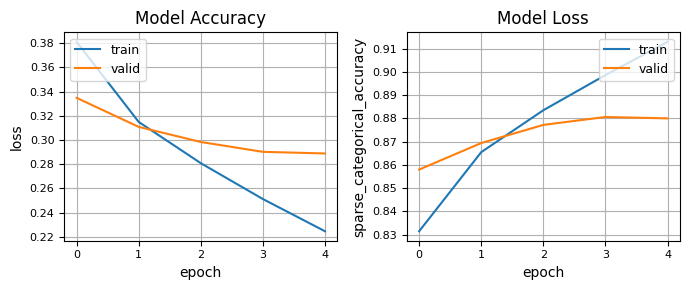

Model performance on the test set: 0.8797199726104736


In [49]:
# default dropout, lower number of training epochs
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)
plot_history(history)
accuracy["FT-1"] = model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"]
print("Model performance on the test set:", accuracy["FT-1"])

In [33]:
model = get_model(dropout=0.3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)
plot_history(history)
accuracy["FT-2"] = model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"]
print("Model performance on the test set:", accuracy["FT-2"])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 47ms/step - accuracy: 0.8088 - loss: 0.4166 - val_accuracy: 0.8580 - val_loss: 0.3357
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.8587 - loss: 0.3334 - val_accuracy: 0.8712 - val_loss: 0.3111
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.8799 - loss: 0.2923 - val_accuracy: 0.8758 - val_loss: 0.2979
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8964 - loss: 0.2606 - val_accuracy: 0.8826 - val_loss: 0.2912
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9108 - loss: 0.2333 - val_accuracy: 0.8860 - val_loss: 0.2879
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9215 - loss: 0.2064 - val_accuracy: 0.8852 - val_loss: 0.2911
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9353 - loss: 0.1762 - val_accuracy: 0.8874 - val_loss: 0.2993
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9469 - loss: 0.1500 - 

NameError: name 'plot_history' is not defined

Model overfits the training set.

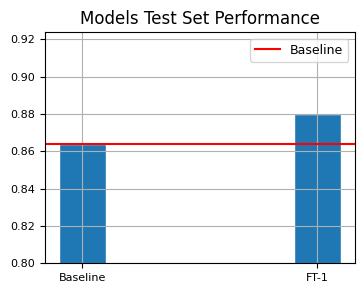

In [95]:
plot_stats(accuracy)

## Inference